[this demo requires doom installed either from gym-pool or from [ppaquette's repo](https://github.com/ppaquette/gym-doom)]

## Basic Doom demo

* This demo solves DoomBasic env with a simple q-learning with experience replay.

# Experiment setup
* Here we basically just load the game and check that it works

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%env THEANO_FLAGS=device=cuda,floatX=float32

env: THEANO_FLAGS=device=cuda,floatX=float32


In [2]:
import gym
import ppaquette_gym_doom
from gym.wrappers import SkipWrapper
from ppaquette_gym_doom.wrappers.action_space import ToDiscrete
from agentnet.experiments.openai_gym.wrappers import PreprocessImage
GAME_NAME = 'ppaquette/DoomCorridor-v0'

make_env = lambda: PreprocessImage(SkipWrapper(4)(ToDiscrete("minimal")(gym.make(GAME_NAME))),
                                   width=80,height=80,grayscale=True)

env = make_env()

Using cuDNN version 5110 on context None
Mapped name None to device cuda: Tesla K80 (0000:00:1E.0)
[2017-06-27 00:58:59,522] Making new env: ppaquette/DoomCorridor-v0


In [3]:
#global params.
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
#number of parallel agents and batch sequence length (frames)
N_AGENTS = 1
SEQ_LENGTH = 10

0.0 False


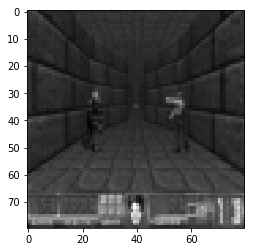

In [4]:
env.reset()
obs,r,done,_=env.step(1)
print(r, done)
plt.imshow(obs[0],cmap='gray',interpolation='none')

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using simple convolutional neural network.

![scheme](https://s18.postimg.org/gbmsq6gmx/dqn_scheme.png)

In [5]:
#setup and import theano/lasagne. Prefer GPU
%env THEANO_FLAGS=device=cuda,floatX=float32

import theano, lasagne
from lasagne.layers import *

env: THEANO_FLAGS=device=cuda,floatX=float32


In [6]:
#observation
observation_layer = InputLayer((None,)+observation_shape,)

#4-tick window over images
from agentnet.memory import WindowAugmentation, LSTMCell

prev_wnd = InputLayer((None,4)+observation_shape)
new_wnd = WindowAugmentation(observation_layer,prev_wnd)
        
#reshape to (frame, h,w). If you don't use grayscale, 4 should become 12.
wnd_reshape = reshape(new_wnd, (-1,4*observation_shape[0])+observation_shape[1:])


In [7]:
from lasagne.nonlinearities import elu,tanh,softmax
#main neural network body.
#note that we use batch normalization here which speeds up training but may
#get unstable if you use small experience replay buffer
conv0 = Conv2DLayer(wnd_reshape,32,filter_size=(8,8),stride=(4,4),name='conv0')

conv1 = Conv2DLayer(batch_norm(conv0),64,filter_size=(4,4),stride=(2,2),name='conv1')

dense = DenseLayer(batch_norm(conv1),512,name='dense',nonlinearity = lasagne.nonlinearities.tanh)        


In [8]:

#baseline for all qvalues
qvalues_layer = DenseLayer(dense,n_actions,nonlinearity=None,name='qval')
        
#sample actions proportionally to policy_layer
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer)


In [9]:
from agentnet.target_network import TargetNetwork
targetnet = TargetNetwork(qvalues_layer)
qvalues_old = targetnet.output_layers

##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [10]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(qvalues_layer,qvalues_old),
              agent_states={new_wnd:prev_wnd},
              action_layers=action_layer)


In [11]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[conv0.W,
 conv0_bn.beta,
 conv0_bn.gamma,
 conv1.W,
 conv1_bn.beta,
 conv1_bn.gamma,
 dense.W,
 dense.b,
 qval.W,
 qval.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [12]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,make_env, 
               n_games=N_AGENTS,
               max_size=300) #experience replay pool holding last 1k sessions


[2017-06-27 00:59:00,395] Making new env: ppaquette/DoomCorridor-v0


In [13]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_log[:2])
print(reward_log[:2])

[[4 1 3 5 5 0 4]]
[[ 0.  0.  0.  0.  0.  0.  0.]]
CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 83.2 ms


In [14]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Q-learning
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

In [15]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,(qvalues_seq,old_qvalues_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)



In [16]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import qlearning

#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      qvalues_target=old_qvalues_seq,
                                                      gamma_or_gammas=0.99)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [17]:
# Compute weight updates
updates = lasagne.updates.adam(loss,weights)

#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

In [18]:
action_layer.epsilon.set_value(0)
untrained_reward = np.mean(pool.evaluate(save_path="./records",record_video=True,n_games=10))

[2017-06-27 00:59:30,889] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 00:59:30,897] Clearing 12 monitor files from previous run (because force=True was provided)
[2017-06-27 00:59:31,141] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.18145.video000000.mp4
[2017-06-27 00:59:38,544] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.18145.video000001.mp4


Episode finished after 420 timesteps with reward=619.6599731445312
Episode finished after 74 timesteps with reward=55.565185546875
Episode finished after 65 timesteps with reward=352.19871520996094
Episode finished after 80 timesteps with reward=39.92762756347656
Episode finished after 45 timesteps with reward=15.961837768554688
Episode finished after 60 timesteps with reward=317.4081573486328
Episode finished after 90 timesteps with reward=581.0654296875


[2017-06-27 00:59:45,683] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.0.18145.video000008.mp4


Episode finished after 51 timesteps with reward=-68.173583984375
Episode finished after 69 timesteps with reward=269.0601348876953


[2017-06-27 00:59:48,474] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Episode finished after 63 timesteps with reward=40.193511962890625


In [19]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Training loop

In [20]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {0:[untrained_reward]}


In [21]:
from tqdm import trange
#the loop may take eons to finish.
#consider interrupting early.
for i in trange(2000):    
    
    
    #train
    pool.update(SEQ_LENGTH, append=True)
    
    loss = train_step()
    
    targetnet.load_weights(0.01)
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    current_epsilon = 0.05 + 0.95*np.exp(-epoch_counter/200.)
    action_layer.epsilon.set_value(np.float32(current_epsilon))
    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = pool.experience_replay.rewards.get_value().mean()
        print("iter=%i\tepsilon=%.3f\treward/step=%.5f"%(epoch_counter,
                                                         current_epsilon,
                                                         pool_mean_reward))
        
    ##record current learning progress and show learning curves
    if epoch_counter%50 ==0:
        rewards[epoch_counter] = pool.evaluate(5, record_video=False)
    
    epoch_counter  +=1

    
# Time to drink some coffee!

  1%|          | 11/2000 [00:02<07:33,  4.39it/s]

iter=10	epsilon=0.954	reward/step=2.89163


  1%|          | 21/2000 [00:04<07:32,  4.38it/s]

iter=20	epsilon=0.910	reward/step=1.69263


  2%|▏         | 31/2000 [00:07<07:29,  4.38it/s]

iter=30	epsilon=0.868	reward/step=3.74129


  2%|▏         | 41/2000 [00:09<07:23,  4.41it/s]

iter=40	epsilon=0.828	reward/step=2.51663


  2%|▏         | 49/2000 [00:11<07:55,  4.10it/s][2017-06-27 01:00:00,297] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:00:00,304] Clearing 8 monitor files from previous run (because force=True was provided)


iter=50	epsilon=0.790	reward/step=3.70828
Episode finished after 46 timesteps with reward=335.2664489746094
Episode finished after 49 timesteps with reward=460.98974609375
Episode finished after 47 timesteps with reward=476.9317169189453
Episode finished after 42 timesteps with reward=203.15736389160156


[2017-06-27 01:00:03,824] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  2%|▎         | 50/2000 [00:15<42:56,  1.32s/it]

Episode finished after 62 timesteps with reward=390.40342712402344


  3%|▎         | 61/2000 [00:18<08:27,  3.82it/s]

iter=60	epsilon=0.754	reward/step=4.31290


  4%|▎         | 70/2000 [00:20<08:17,  3.88it/s]

iter=70	epsilon=0.719	reward/step=4.96162


  4%|▍         | 80/2000 [00:22<08:06,  3.94it/s]

iter=80	epsilon=0.687	reward/step=5.11334


  4%|▍         | 90/2000 [00:25<08:16,  3.85it/s]

iter=90	epsilon=0.656	reward/step=5.90909


  5%|▍         | 99/2000 [00:27<07:54,  4.01it/s][2017-06-27 01:00:16,246] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:00:16,251] Clearing 2 monitor files from previous run (because force=True was provided)


iter=100	epsilon=0.626	reward/step=6.14729
Episode finished after 53 timesteps with reward=134.90814208984375
Episode finished after 46 timesteps with reward=398.0626678466797
Episode finished after 39 timesteps with reward=376.5001220703125
Episode finished after 62 timesteps with reward=552.6234436035156


[2017-06-27 01:00:19,952] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  5%|▌         | 100/2000 [00:31<43:43,  1.38s/it]

Episode finished after 64 timesteps with reward=839.3578186035156


  6%|▌         | 110/2000 [00:33<09:24,  3.35it/s]

iter=110	epsilon=0.598	reward/step=6.32873


  6%|▌         | 120/2000 [00:36<08:32,  3.67it/s]

iter=120	epsilon=0.571	reward/step=6.62783


  6%|▋         | 130/2000 [00:39<08:32,  3.65it/s]

iter=130	epsilon=0.546	reward/step=6.74801


  7%|▋         | 140/2000 [00:41<08:35,  3.61it/s]

iter=140	epsilon=0.522	reward/step=7.32147


  7%|▋         | 149/2000 [00:44<08:17,  3.72it/s][2017-06-27 01:00:33,065] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:00:33,070] Clearing 2 monitor files from previous run (because force=True was provided)


iter=150	epsilon=0.499	reward/step=7.63401
Episode finished after 50 timesteps with reward=861.8364868164062
Episode finished after 40 timesteps with reward=590.7874603271484
Episode finished after 56 timesteps with reward=842.1662902832031
Episode finished after 47 timesteps with reward=866.8045043945312


[2017-06-27 01:00:36,291] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
  8%|▊         | 150/2000 [00:47<38:45,  1.26s/it]

Episode finished after 34 timesteps with reward=422.50929260253906


  8%|▊         | 160/2000 [00:50<09:35,  3.20it/s]

iter=160	epsilon=0.477	reward/step=7.88752


  8%|▊         | 170/2000 [00:53<08:45,  3.48it/s]

iter=170	epsilon=0.456	reward/step=8.05973


  9%|▉         | 180/2000 [00:56<08:44,  3.47it/s]

iter=180	epsilon=0.436	reward/step=8.07448


 10%|▉         | 190/2000 [00:58<08:55,  3.38it/s]

iter=190	epsilon=0.417	reward/step=8.40919


 10%|▉         | 199/2000 [01:01<08:41,  3.45it/s][2017-06-27 01:00:50,273] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:00:50,278] Clearing 2 monitor files from previous run (because force=True was provided)


iter=200	epsilon=0.399	reward/step=8.49671
Episode finished after 46 timesteps with reward=894.1930236816406
Episode finished after 29 timesteps with reward=422.4984436035156
Episode finished after 42 timesteps with reward=499.0796203613281
Episode finished after 35 timesteps with reward=312.9708557128906


[2017-06-27 01:00:52,994] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 10%|█         | 200/2000 [01:04<33:45,  1.13s/it]

Episode finished after 33 timesteps with reward=408.3773651123047


 10%|█         | 210/2000 [01:07<09:52,  3.02it/s]

iter=210	epsilon=0.382	reward/step=8.58315


 11%|█         | 220/2000 [01:10<09:37,  3.08it/s]

iter=220	epsilon=0.366	reward/step=8.92074


 12%|█▏        | 230/2000 [01:13<09:50,  3.00it/s]

iter=230	epsilon=0.351	reward/step=9.07481


 12%|█▏        | 240/2000 [01:17<09:55,  2.96it/s]

iter=240	epsilon=0.336	reward/step=9.28634


 12%|█▏        | 249/2000 [01:19<09:38,  3.03it/s][2017-06-27 01:01:08,873] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:01:08,881] Clearing 2 monitor files from previous run (because force=True was provided)


iter=250	epsilon=0.322	reward/step=9.51130
Episode finished after 56 timesteps with reward=919.1798248291016
Episode finished after 44 timesteps with reward=1050.9606628417969
Episode finished after 37 timesteps with reward=621.8755340576172
Episode finished after 51 timesteps with reward=869.2304382324219


[2017-06-27 01:01:12,003] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 12%|█▎        | 250/2000 [01:23<37:35,  1.29s/it]

Episode finished after 30 timesteps with reward=549.5291900634766


 13%|█▎        | 260/2000 [01:26<10:48,  2.68it/s]

iter=260	epsilon=0.309	reward/step=9.79269


 14%|█▎        | 270/2000 [01:30<10:03,  2.87it/s]

iter=270	epsilon=0.296	reward/step=9.93036


 14%|█▍        | 280/2000 [01:33<10:08,  2.83it/s]

iter=280	epsilon=0.284	reward/step=10.57928


 14%|█▍        | 290/2000 [01:37<10:15,  2.78it/s]

iter=290	epsilon=0.273	reward/step=10.87134


 15%|█▍        | 299/2000 [01:40<09:57,  2.85it/s][2017-06-27 01:01:29,154] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:01:29,160] Clearing 2 monitor files from previous run (because force=True was provided)


iter=300	epsilon=0.262	reward/step=11.60365
Episode finished after 54 timesteps with reward=2277.581085205078
Episode finished after 53 timesteps with reward=724.2173614501953
Episode finished after 33 timesteps with reward=698.47705078125
Episode finished after 29 timesteps with reward=592.0419921875


[2017-06-27 01:01:31,965] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 15%|█▌        | 300/2000 [01:43<34:22,  1.21s/it]

Episode finished after 26 timesteps with reward=576.644287109375


 16%|█▌        | 310/2000 [01:46<10:42,  2.63it/s]

iter=310	epsilon=0.252	reward/step=11.97840


 16%|█▌        | 320/2000 [01:50<09:59,  2.80it/s]

iter=320	epsilon=0.242	reward/step=12.89187


 16%|█▋        | 330/2000 [01:53<09:46,  2.85it/s]

iter=330	epsilon=0.232	reward/step=13.21550


 17%|█▋        | 340/2000 [01:57<09:42,  2.85it/s]

iter=340	epsilon=0.224	reward/step=14.50075


 17%|█▋        | 349/2000 [02:00<09:22,  2.94it/s][2017-06-27 01:01:49,059] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:01:49,064] Clearing 2 monitor files from previous run (because force=True was provided)


iter=350	epsilon=0.215	reward/step=14.91513
Episode finished after 54 timesteps with reward=944.5041961669922
Episode finished after 45 timesteps with reward=2276.4895629882812
Episode finished after 60 timesteps with reward=2276.919677734375
Episode finished after 48 timesteps with reward=811.1809539794922


[2017-06-27 01:01:52,462] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 18%|█▊        | 350/2000 [02:03<37:59,  1.38s/it]

Episode finished after 35 timesteps with reward=459.18048095703125


 18%|█▊        | 360/2000 [02:07<10:24,  2.63it/s]

iter=360	epsilon=0.207	reward/step=15.27736


 18%|█▊        | 370/2000 [02:10<09:30,  2.86it/s]

iter=370	epsilon=0.199	reward/step=16.60179


 19%|█▉        | 380/2000 [02:14<09:31,  2.84it/s]

iter=380	epsilon=0.192	reward/step=17.04600


 20%|█▉        | 390/2000 [02:17<09:25,  2.85it/s]

iter=390	epsilon=0.185	reward/step=17.27995


 20%|█▉        | 399/2000 [02:20<09:05,  2.94it/s][2017-06-27 01:02:09,480] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:02:09,484] Clearing 2 monitor files from previous run (because force=True was provided)


iter=400	epsilon=0.179	reward/step=17.70054
Episode finished after 35 timesteps with reward=390.1068420410156
Episode finished after 35 timesteps with reward=895.2181854248047
Episode finished after 29 timesteps with reward=752.9567718505859
Episode finished after 37 timesteps with reward=553.3306121826172


[2017-06-27 01:02:12,166] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 20%|██        | 400/2000 [02:23<30:59,  1.16s/it]

Episode finished after 50 timesteps with reward=2277.6788635253906


 20%|██        | 410/2000 [02:27<10:02,  2.64it/s]

iter=410	epsilon=0.172	reward/step=17.98644


 21%|██        | 420/2000 [02:30<09:21,  2.82it/s]

iter=420	epsilon=0.166	reward/step=18.45321


 22%|██▏       | 430/2000 [02:33<09:15,  2.83it/s]

iter=430	epsilon=0.161	reward/step=19.32962


 22%|██▏       | 440/2000 [02:37<09:08,  2.84it/s]

iter=440	epsilon=0.155	reward/step=19.42015


 22%|██▏       | 449/2000 [02:40<08:52,  2.91it/s][2017-06-27 01:02:29,314] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:02:29,319] Clearing 2 monitor files from previous run (because force=True was provided)


iter=450	epsilon=0.150	reward/step=19.76658
Episode finished after 42 timesteps with reward=2276.815719604492
Episode finished after 47 timesteps with reward=827.4177856445312
Episode finished after 43 timesteps with reward=2278.5723419189453
Episode finished after 38 timesteps with reward=806.7581787109375


[2017-06-27 01:02:32,237] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 22%|██▎       | 450/2000 [02:43<32:02,  1.24s/it]

Episode finished after 35 timesteps with reward=2280.221710205078


 23%|██▎       | 460/2000 [02:47<09:48,  2.62it/s]

iter=460	epsilon=0.145	reward/step=20.63627


 24%|██▎       | 470/2000 [02:50<09:05,  2.80it/s]

iter=470	epsilon=0.141	reward/step=21.43344


 24%|██▍       | 480/2000 [02:54<08:59,  2.82it/s]

iter=480	epsilon=0.136	reward/step=21.99444


 24%|██▍       | 490/2000 [02:57<08:55,  2.82it/s]

iter=490	epsilon=0.132	reward/step=22.98674


 25%|██▍       | 499/2000 [03:00<08:30,  2.94it/s][2017-06-27 01:02:49,409] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:02:49,414] Clearing 2 monitor files from previous run (because force=True was provided)


iter=500	epsilon=0.128	reward/step=23.83699
Episode finished after 31 timesteps with reward=761.2829132080078
Episode finished after 53 timesteps with reward=919.8325500488281
Episode finished after 36 timesteps with reward=997.7441253662109
Episode finished after 27 timesteps with reward=595.5919189453125


[2017-06-27 01:02:51,988] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 25%|██▌       | 500/2000 [03:03<28:17,  1.13s/it]

Episode finished after 31 timesteps with reward=392.3008575439453


 26%|██▌       | 510/2000 [03:06<09:19,  2.66it/s]

iter=510	epsilon=0.124	reward/step=24.71967


 26%|██▌       | 520/2000 [03:10<08:47,  2.81it/s]

iter=520	epsilon=0.121	reward/step=25.03335


 26%|██▋       | 530/2000 [03:13<08:36,  2.84it/s]

iter=530	epsilon=0.117	reward/step=25.21330


 27%|██▋       | 540/2000 [03:17<08:37,  2.82it/s]

iter=540	epsilon=0.114	reward/step=25.95399


 27%|██▋       | 549/2000 [03:20<08:16,  2.92it/s][2017-06-27 01:03:09,143] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:03:09,148] Clearing 2 monitor files from previous run (because force=True was provided)


iter=550	epsilon=0.111	reward/step=26.62381
Episode finished after 66 timesteps with reward=2276.094436645508
Episode finished after 31 timesteps with reward=901.7236175537109
Episode finished after 39 timesteps with reward=1015.5735473632812
Episode finished after 49 timesteps with reward=1076.5906829833984


[2017-06-27 01:03:12,263] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 28%|██▊       | 550/2000 [03:23<31:24,  1.30s/it]

Episode finished after 35 timesteps with reward=2279.1160888671875


 28%|██▊       | 560/2000 [03:27<09:11,  2.61it/s]

iter=560	epsilon=0.108	reward/step=27.20776


 28%|██▊       | 570/2000 [03:30<08:25,  2.83it/s]

iter=570	epsilon=0.105	reward/step=27.63276


 29%|██▉       | 580/2000 [03:34<08:21,  2.83it/s]

iter=580	epsilon=0.102	reward/step=27.30981


 30%|██▉       | 590/2000 [03:37<08:18,  2.83it/s]

iter=590	epsilon=0.100	reward/step=28.36772


 30%|██▉       | 599/2000 [03:40<08:01,  2.91it/s][2017-06-27 01:03:29,436] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:03:29,441] Clearing 2 monitor files from previous run (because force=True was provided)


iter=600	epsilon=0.097	reward/step=28.46691
Episode finished after 34 timesteps with reward=2278.4652252197266
Episode finished after 33 timesteps with reward=802.2808685302734
Episode finished after 39 timesteps with reward=2276.587677001953
Episode finished after 37 timesteps with reward=2283.972671508789


[2017-06-27 01:03:32,126] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 30%|███       | 600/2000 [03:43<27:10,  1.16s/it]

Episode finished after 43 timesteps with reward=772.3943786621094


 30%|███       | 610/2000 [03:46<08:40,  2.67it/s]

iter=610	epsilon=0.095	reward/step=29.64100


 31%|███       | 620/2000 [03:50<08:01,  2.86it/s]

iter=620	epsilon=0.093	reward/step=28.59078


 32%|███▏      | 630/2000 [03:53<07:57,  2.87it/s]

iter=630	epsilon=0.091	reward/step=29.02666


 32%|███▏      | 640/2000 [03:57<07:58,  2.84it/s]

iter=640	epsilon=0.089	reward/step=28.48971


 32%|███▏      | 649/2000 [04:00<07:35,  2.96it/s][2017-06-27 01:03:49,095] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:03:49,100] Clearing 2 monitor files from previous run (because force=True was provided)


iter=650	epsilon=0.087	reward/step=29.36247
Episode finished after 32 timesteps with reward=805.9324340820312
Episode finished after 37 timesteps with reward=760.9263610839844
Episode finished after 26 timesteps with reward=701.4460754394531
Episode finished after 35 timesteps with reward=852.5287933349609


[2017-06-27 01:03:51,568] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 32%|███▎      | 650/2000 [04:03<24:39,  1.10s/it]

Episode finished after 40 timesteps with reward=2276.2073364257812


 33%|███▎      | 660/2000 [04:06<08:22,  2.67it/s]

iter=660	epsilon=0.085	reward/step=29.84828


 34%|███▎      | 670/2000 [04:09<07:49,  2.83it/s]

iter=670	epsilon=0.083	reward/step=29.39237


 34%|███▍      | 680/2000 [04:13<07:47,  2.82it/s]

iter=680	epsilon=0.082	reward/step=29.62929


 34%|███▍      | 690/2000 [04:16<07:49,  2.79it/s]

iter=690	epsilon=0.080	reward/step=29.96876


 35%|███▍      | 699/2000 [04:19<07:24,  2.92it/s][2017-06-27 01:04:08,706] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:04:08,711] Clearing 2 monitor files from previous run (because force=True was provided)


iter=700	epsilon=0.079	reward/step=30.47762
Episode finished after 35 timesteps with reward=2277.345718383789
Episode finished after 34 timesteps with reward=1123.957763671875
Episode finished after 51 timesteps with reward=961.134765625
Episode finished after 32 timesteps with reward=750.2739105224609


[2017-06-27 01:04:11,359] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 35%|███▌      | 700/2000 [04:22<25:03,  1.16s/it]

Episode finished after 31 timesteps with reward=1000.0382537841797


 36%|███▌      | 710/2000 [04:26<08:07,  2.64it/s]

iter=710	epsilon=0.077	reward/step=30.76269


 36%|███▌      | 720/2000 [04:29<07:34,  2.82it/s]

iter=720	epsilon=0.076	reward/step=30.57550


 36%|███▋      | 730/2000 [04:33<07:24,  2.86it/s]

iter=730	epsilon=0.075	reward/step=30.59974


 37%|███▋      | 740/2000 [04:36<07:27,  2.81it/s]

iter=740	epsilon=0.073	reward/step=31.13199


 37%|███▋      | 749/2000 [04:39<07:06,  2.93it/s][2017-06-27 01:04:28,519] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:04:28,524] Clearing 2 monitor files from previous run (because force=True was provided)


iter=750	epsilon=0.072	reward/step=31.13025
Episode finished after 30 timesteps with reward=432.349853515625
Episode finished after 44 timesteps with reward=927.0829772949219
Episode finished after 36 timesteps with reward=2283.903091430664
Episode finished after 41 timesteps with reward=902.1521148681641


[2017-06-27 01:04:31,252] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 38%|███▊      | 750/2000 [04:42<24:30,  1.18s/it]

Episode finished after 38 timesteps with reward=850.0609283447266


 38%|███▊      | 760/2000 [04:46<07:45,  2.67it/s]

iter=760	epsilon=0.071	reward/step=30.04468


 38%|███▊      | 770/2000 [04:49<07:12,  2.85it/s]

iter=770	epsilon=0.070	reward/step=29.01749


 39%|███▉      | 780/2000 [04:52<07:11,  2.83it/s]

iter=780	epsilon=0.069	reward/step=29.33253


 40%|███▉      | 790/2000 [04:56<07:09,  2.82it/s]

iter=790	epsilon=0.068	reward/step=29.14847


 40%|███▉      | 799/2000 [04:59<06:53,  2.90it/s][2017-06-27 01:04:48,399] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:04:48,404] Clearing 2 monitor files from previous run (because force=True was provided)


iter=800	epsilon=0.067	reward/step=29.69556
Episode finished after 40 timesteps with reward=2276.0565490722656
Episode finished after 35 timesteps with reward=2277.048614501953
Episode finished after 41 timesteps with reward=1135.6983489990234
Episode finished after 35 timesteps with reward=828.6763916015625


[2017-06-27 01:04:51,119] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 40%|████      | 800/2000 [05:02<23:29,  1.17s/it]

Episode finished after 37 timesteps with reward=926.6159362792969


 40%|████      | 810/2000 [05:06<07:48,  2.54it/s]

iter=810	epsilon=0.067	reward/step=30.45357


 41%|████      | 820/2000 [05:09<07:00,  2.81it/s]

iter=820	epsilon=0.066	reward/step=30.82626


 42%|████▏     | 830/2000 [05:13<06:53,  2.83it/s]

iter=830	epsilon=0.065	reward/step=31.46167


 42%|████▏     | 840/2000 [05:16<06:46,  2.86it/s]

iter=840	epsilon=0.064	reward/step=31.57572


 42%|████▏     | 849/2000 [05:19<06:32,  2.93it/s][2017-06-27 01:05:08,547] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:05:08,552] Clearing 2 monitor files from previous run (because force=True was provided)


iter=850	epsilon=0.064	reward/step=31.80829
Episode finished after 28 timesteps with reward=897.4129638671875
Episode finished after 54 timesteps with reward=795.8829803466797
Episode finished after 42 timesteps with reward=2282.037796020508
Episode finished after 36 timesteps with reward=804.3627777099609


[2017-06-27 01:05:11,366] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 42%|████▎     | 850/2000 [05:22<23:08,  1.21s/it]

Episode finished after 35 timesteps with reward=1008.9905242919922


 43%|████▎     | 860/2000 [05:26<07:11,  2.64it/s]

iter=860	epsilon=0.063	reward/step=31.30355


 44%|████▎     | 870/2000 [05:29<06:34,  2.86it/s]

iter=870	epsilon=0.062	reward/step=31.58392


 44%|████▍     | 880/2000 [05:33<06:32,  2.85it/s]

iter=880	epsilon=0.062	reward/step=31.59053


 44%|████▍     | 890/2000 [05:36<06:29,  2.85it/s]

iter=890	epsilon=0.061	reward/step=31.24030


 45%|████▍     | 899/2000 [05:39<06:14,  2.94it/s][2017-06-27 01:05:28,414] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:05:28,418] Clearing 2 monitor files from previous run (because force=True was provided)


iter=900	epsilon=0.061	reward/step=32.05826
Episode finished after 27 timesteps with reward=763.8812103271484
Episode finished after 28 timesteps with reward=599.3265838623047
Episode finished after 40 timesteps with reward=2278.5162811279297
Episode finished after 33 timesteps with reward=836.7554016113281


[2017-06-27 01:05:30,801] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 45%|████▌     | 900/2000 [05:42<19:45,  1.08s/it]

Episode finished after 34 timesteps with reward=2276.163604736328


 46%|████▌     | 910/2000 [05:45<06:48,  2.67it/s]

iter=910	epsilon=0.060	reward/step=32.16965


 46%|████▌     | 920/2000 [05:49<06:20,  2.84it/s]

iter=920	epsilon=0.060	reward/step=33.87628


 46%|████▋     | 930/2000 [05:52<06:28,  2.75it/s]

iter=930	epsilon=0.059	reward/step=34.58097


 47%|████▋     | 940/2000 [05:55<06:11,  2.85it/s]

iter=940	epsilon=0.059	reward/step=35.44445


 47%|████▋     | 949/2000 [05:59<06:02,  2.90it/s][2017-06-27 01:05:47,977] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:05:47,982] Clearing 2 monitor files from previous run (because force=True was provided)


iter=950	epsilon=0.058	reward/step=34.52916
Episode finished after 34 timesteps with reward=827.0018310546875
Episode finished after 34 timesteps with reward=2279.442367553711
Episode finished after 24 timesteps with reward=654.9808807373047
Episode finished after 35 timesteps with reward=905.4264984130859


[2017-06-27 01:05:50,381] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 48%|████▊     | 950/2000 [06:01<18:58,  1.08s/it]

Episode finished after 36 timesteps with reward=752.8391723632812


 48%|████▊     | 960/2000 [06:05<06:25,  2.70it/s]

iter=960	epsilon=0.058	reward/step=33.50945


 48%|████▊     | 970/2000 [06:08<06:02,  2.84it/s]

iter=970	epsilon=0.057	reward/step=34.06074


 49%|████▉     | 980/2000 [06:12<05:56,  2.86it/s]

iter=980	epsilon=0.057	reward/step=34.39312


 50%|████▉     | 990/2000 [06:15<05:53,  2.86it/s]

iter=990	epsilon=0.057	reward/step=34.09402


 50%|████▉     | 999/2000 [06:18<05:42,  2.92it/s][2017-06-27 01:06:07,424] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:06:07,429] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1000	epsilon=0.056	reward/step=33.47522
Episode finished after 31 timesteps with reward=802.7084045410156
Episode finished after 32 timesteps with reward=333.76031494140625
Episode finished after 37 timesteps with reward=2278.5574798583984
Episode finished after 30 timesteps with reward=771.3849182128906


[2017-06-27 01:06:09,830] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 50%|█████     | 1000/2000 [06:21<18:04,  1.08s/it]

Episode finished after 34 timesteps with reward=792.7579498291016


 50%|█████     | 1010/2000 [06:24<06:09,  2.68it/s]

iter=1010	epsilon=0.056	reward/step=33.82328


 51%|█████     | 1020/2000 [06:28<05:45,  2.84it/s]

iter=1020	epsilon=0.056	reward/step=34.39929


 52%|█████▏    | 1030/2000 [06:31<05:40,  2.85it/s]

iter=1030	epsilon=0.056	reward/step=33.79246


 52%|█████▏    | 1040/2000 [06:34<05:34,  2.87it/s]

iter=1040	epsilon=0.055	reward/step=33.73231


 52%|█████▏    | 1049/2000 [06:37<05:32,  2.86it/s][2017-06-27 01:06:26,885] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:06:26,890] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1050	epsilon=0.055	reward/step=34.26493
Episode finished after 34 timesteps with reward=2282.417007446289
Episode finished after 35 timesteps with reward=2285.1615600585938
Episode finished after 34 timesteps with reward=2282.804931640625
Episode finished after 31 timesteps with reward=834.1009979248047


[2017-06-27 01:06:29,321] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 52%|█████▎    | 1050/2000 [06:40<17:23,  1.10s/it]

Episode finished after 31 timesteps with reward=472.3924102783203


 53%|█████▎    | 1060/2000 [06:44<06:00,  2.61it/s]

iter=1060	epsilon=0.055	reward/step=35.68690


 54%|█████▎    | 1070/2000 [06:47<05:28,  2.83it/s]

iter=1070	epsilon=0.055	reward/step=36.17459


 54%|█████▍    | 1080/2000 [06:51<05:23,  2.85it/s]

iter=1080	epsilon=0.054	reward/step=35.69733


 55%|█████▍    | 1090/2000 [06:54<05:17,  2.87it/s]

iter=1090	epsilon=0.054	reward/step=36.01778


 55%|█████▍    | 1099/2000 [06:57<05:05,  2.95it/s][2017-06-27 01:06:46,351] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:06:46,356] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1100	epsilon=0.054	reward/step=35.95311
Episode finished after 32 timesteps with reward=1029.1439819335938
Episode finished after 36 timesteps with reward=2278.1190032958984
Episode finished after 34 timesteps with reward=2284.681854248047
Episode finished after 31 timesteps with reward=728.5377044677734


[2017-06-27 01:06:48,825] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 55%|█████▌    | 1100/2000 [07:00<16:26,  1.10s/it]

Episode finished after 37 timesteps with reward=2284.309600830078


 56%|█████▌    | 1110/2000 [07:03<05:32,  2.68it/s]

iter=1110	epsilon=0.054	reward/step=34.83153


 56%|█████▌    | 1120/2000 [07:07<05:07,  2.86it/s]

iter=1120	epsilon=0.054	reward/step=35.22215


 56%|█████▋    | 1130/2000 [07:10<05:07,  2.83it/s]

iter=1130	epsilon=0.053	reward/step=34.80867


 57%|█████▋    | 1140/2000 [07:13<05:04,  2.83it/s]

iter=1140	epsilon=0.053	reward/step=34.24681


 57%|█████▋    | 1149/2000 [07:16<04:49,  2.94it/s][2017-06-27 01:07:05,870] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:07:05,875] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1150	epsilon=0.053	reward/step=33.59414
Episode finished after 34 timesteps with reward=2279.5372161865234
Episode finished after 59 timesteps with reward=2276.1016998291016
Episode finished after 59 timesteps with reward=818.1522216796875
Episode finished after 31 timesteps with reward=934.8555297851562


[2017-06-27 01:07:08,964] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 57%|█████▊    | 1150/2000 [07:20<18:14,  1.29s/it]

Episode finished after 34 timesteps with reward=2285.094451904297


 58%|█████▊    | 1160/2000 [07:23<05:25,  2.58it/s]

iter=1160	epsilon=0.053	reward/step=34.14389


 58%|█████▊    | 1170/2000 [07:27<04:51,  2.84it/s]

iter=1170	epsilon=0.053	reward/step=33.68037


 59%|█████▉    | 1180/2000 [07:30<04:48,  2.85it/s]

iter=1180	epsilon=0.053	reward/step=33.97090


 60%|█████▉    | 1190/2000 [07:34<04:44,  2.85it/s]

iter=1190	epsilon=0.052	reward/step=33.60183


 60%|█████▉    | 1199/2000 [07:37<04:30,  2.96it/s][2017-06-27 01:07:26,042] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:07:26,047] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1200	epsilon=0.052	reward/step=33.28833
Episode finished after 50 timesteps with reward=100.25532531738281
Episode finished after 33 timesteps with reward=847.9771423339844
Episode finished after 33 timesteps with reward=2276.3172149658203
Episode finished after 41 timesteps with reward=819.2161560058594


[2017-06-27 01:07:28,812] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 60%|██████    | 1200/2000 [07:40<15:47,  1.18s/it]

Episode finished after 37 timesteps with reward=2282.354690551758


 60%|██████    | 1210/2000 [07:43<04:54,  2.68it/s]

iter=1210	epsilon=0.052	reward/step=32.85514


 61%|██████    | 1220/2000 [07:47<04:34,  2.84it/s]

iter=1220	epsilon=0.052	reward/step=32.10843


 62%|██████▏   | 1230/2000 [07:50<04:27,  2.88it/s]

iter=1230	epsilon=0.052	reward/step=31.99057


 62%|██████▏   | 1240/2000 [07:53<04:26,  2.85it/s]

iter=1240	epsilon=0.052	reward/step=31.69980


 62%|██████▏   | 1249/2000 [07:56<04:14,  2.95it/s][2017-06-27 01:07:45,775] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:07:45,780] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1250	epsilon=0.052	reward/step=32.21821
Episode finished after 36 timesteps with reward=2280.9578857421875
Episode finished after 28 timesteps with reward=641.8248901367188
Episode finished after 31 timesteps with reward=889.1630249023438
Episode finished after 34 timesteps with reward=2278.7420959472656


[2017-06-27 01:07:48,169] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 62%|██████▎   | 1250/2000 [07:59<13:28,  1.08s/it]

Episode finished after 35 timesteps with reward=2282.2191314697266


 63%|██████▎   | 1260/2000 [08:03<04:33,  2.71it/s]

iter=1260	epsilon=0.052	reward/step=32.87367


 64%|██████▎   | 1270/2000 [08:06<04:13,  2.88it/s]

iter=1270	epsilon=0.052	reward/step=32.76422


 64%|██████▍   | 1280/2000 [08:09<04:10,  2.87it/s]

iter=1280	epsilon=0.052	reward/step=32.86822


 64%|██████▍   | 1290/2000 [08:13<04:11,  2.82it/s]

iter=1290	epsilon=0.052	reward/step=32.88466


 65%|██████▍   | 1299/2000 [08:16<04:03,  2.87it/s][2017-06-27 01:08:05,216] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:08:05,220] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1300	epsilon=0.051	reward/step=32.92010
Episode finished after 36 timesteps with reward=2278.2271118164062
Episode finished after 41 timesteps with reward=969.3654479980469
Episode finished after 34 timesteps with reward=1119.1278533935547
Episode finished after 54 timesteps with reward=889.1594848632812


[2017-06-27 01:08:08,071] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 65%|██████▌   | 1300/2000 [08:19<14:17,  1.22s/it]

Episode finished after 32 timesteps with reward=1120.6480255126953


 66%|██████▌   | 1310/2000 [08:22<04:18,  2.67it/s]

iter=1310	epsilon=0.051	reward/step=32.20316


 66%|██████▌   | 1320/2000 [08:26<04:00,  2.83it/s]

iter=1320	epsilon=0.051	reward/step=32.35424


 66%|██████▋   | 1330/2000 [08:29<03:56,  2.84it/s]

iter=1330	epsilon=0.051	reward/step=33.00814


 67%|██████▋   | 1340/2000 [08:33<03:51,  2.84it/s]

iter=1340	epsilon=0.051	reward/step=33.15530


 67%|██████▋   | 1349/2000 [08:36<03:42,  2.92it/s][2017-06-27 01:08:25,142] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:08:25,147] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1350	epsilon=0.051	reward/step=33.57905
Episode finished after 38 timesteps with reward=2276.1282958984375
Episode finished after 40 timesteps with reward=785.7328338623047
Episode finished after 35 timesteps with reward=384.69944763183594
Episode finished after 24 timesteps with reward=762.8460235595703


[2017-06-27 01:08:27,611] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 68%|██████▊   | 1350/2000 [08:39<11:57,  1.10s/it]

Episode finished after 33 timesteps with reward=771.3690338134766


 68%|██████▊   | 1360/2000 [08:42<03:59,  2.68it/s]

iter=1360	epsilon=0.051	reward/step=32.80442


 68%|██████▊   | 1370/2000 [08:45<03:40,  2.86it/s]

iter=1370	epsilon=0.051	reward/step=33.75476


 69%|██████▉   | 1380/2000 [08:49<03:37,  2.84it/s]

iter=1380	epsilon=0.051	reward/step=34.33408


 70%|██████▉   | 1390/2000 [08:52<03:33,  2.86it/s]

iter=1390	epsilon=0.051	reward/step=34.15933


 70%|██████▉   | 1399/2000 [08:55<03:23,  2.96it/s][2017-06-27 01:08:44,644] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:08:44,649] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1400	epsilon=0.051	reward/step=33.19626
Episode finished after 36 timesteps with reward=2280.867919921875
Episode finished after 50 timesteps with reward=789.4605255126953
Episode finished after 34 timesteps with reward=785.6921844482422
Episode finished after 37 timesteps with reward=2280.3851776123047


[2017-06-27 01:08:47,398] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 70%|███████   | 1400/2000 [08:58<11:51,  1.19s/it]

Episode finished after 35 timesteps with reward=1112.7450714111328


 70%|███████   | 1410/2000 [09:02<03:43,  2.65it/s]

iter=1410	epsilon=0.051	reward/step=32.79780


 71%|███████   | 1420/2000 [09:05<03:28,  2.79it/s]

iter=1420	epsilon=0.051	reward/step=31.53196


 72%|███████▏  | 1430/2000 [09:09<03:20,  2.84it/s]

iter=1430	epsilon=0.051	reward/step=31.69211


 72%|███████▏  | 1440/2000 [09:12<03:17,  2.84it/s]

iter=1440	epsilon=0.051	reward/step=31.48277


 72%|███████▏  | 1449/2000 [09:15<03:05,  2.97it/s][2017-06-27 01:09:04,483] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:09:04,488] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1450	epsilon=0.051	reward/step=30.82818
Episode finished after 38 timesteps with reward=2280.722930908203
Episode finished after 28 timesteps with reward=569.7157287597656
Episode finished after 33 timesteps with reward=2276.5055084228516
Episode finished after 39 timesteps with reward=2279.7147521972656


[2017-06-27 01:09:06,995] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 72%|███████▎  | 1450/2000 [09:18<10:12,  1.11s/it]

Episode finished after 35 timesteps with reward=2283.1038818359375


 73%|███████▎  | 1460/2000 [09:21<03:21,  2.68it/s]

iter=1460	epsilon=0.051	reward/step=30.70028


 74%|███████▎  | 1470/2000 [09:25<03:06,  2.84it/s]

iter=1470	epsilon=0.051	reward/step=31.67080


 74%|███████▍  | 1480/2000 [09:28<03:02,  2.84it/s]

iter=1480	epsilon=0.051	reward/step=31.81816


 74%|███████▍  | 1490/2000 [09:32<02:59,  2.84it/s]

iter=1490	epsilon=0.051	reward/step=31.58222


 75%|███████▍  | 1499/2000 [09:35<02:49,  2.96it/s][2017-06-27 01:09:24,044] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:09:24,048] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1500	epsilon=0.051	reward/step=30.92949
Episode finished after 25 timesteps with reward=635.4564208984375
Episode finished after 44 timesteps with reward=-9.501983642578125
Episode finished after 44 timesteps with reward=11.48284912109375
Episode finished after 38 timesteps with reward=2277.7506256103516


[2017-06-27 01:09:27,078] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 75%|███████▌  | 1500/2000 [09:38<10:34,  1.27s/it]

Episode finished after 63 timesteps with reward=2279.3477630615234


 76%|███████▌  | 1510/2000 [09:41<03:04,  2.66it/s]

iter=1510	epsilon=0.050	reward/step=31.37035


 76%|███████▌  | 1520/2000 [09:45<02:48,  2.85it/s]

iter=1520	epsilon=0.050	reward/step=31.99865


 76%|███████▋  | 1530/2000 [09:48<02:43,  2.87it/s]

iter=1530	epsilon=0.050	reward/step=31.54818


 77%|███████▋  | 1540/2000 [09:52<02:44,  2.79it/s]

iter=1540	epsilon=0.050	reward/step=30.85957


 77%|███████▋  | 1549/2000 [09:55<02:32,  2.95it/s][2017-06-27 01:09:44,091] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:09:44,096] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1550	epsilon=0.050	reward/step=31.36216
Episode finished after 30 timesteps with reward=987.3770904541016
Episode finished after 44 timesteps with reward=292.77333068847656
Episode finished after 35 timesteps with reward=2280.634796142578
Episode finished after 35 timesteps with reward=1125.0271606445312


[2017-06-27 01:09:46,661] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 78%|███████▊  | 1550/2000 [09:58<08:28,  1.13s/it]

Episode finished after 33 timesteps with reward=2277.715530395508


 78%|███████▊  | 1560/2000 [10:01<02:44,  2.67it/s]

iter=1560	epsilon=0.050	reward/step=31.80722


 78%|███████▊  | 1570/2000 [10:04<02:30,  2.87it/s]

iter=1570	epsilon=0.050	reward/step=31.17907


 79%|███████▉  | 1580/2000 [10:08<02:27,  2.85it/s]

iter=1580	epsilon=0.050	reward/step=30.99263


 80%|███████▉  | 1590/2000 [10:11<02:24,  2.84it/s]

iter=1590	epsilon=0.050	reward/step=31.33238


 80%|███████▉  | 1599/2000 [10:14<02:16,  2.93it/s][2017-06-27 01:10:03,682] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:10:03,686] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1600	epsilon=0.050	reward/step=31.82029
Episode finished after 33 timesteps with reward=1026.4235229492188
Episode finished after 35 timesteps with reward=2278.8130798339844
Episode finished after 34 timesteps with reward=2277.79248046875
Episode finished after 31 timesteps with reward=556.6439208984375


[2017-06-27 01:10:06,118] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 80%|████████  | 1600/2000 [10:17<07:17,  1.09s/it]

Episode finished after 34 timesteps with reward=1050.5899353027344


 80%|████████  | 1610/2000 [10:21<02:27,  2.65it/s]

iter=1610	epsilon=0.050	reward/step=32.60418


 81%|████████  | 1620/2000 [10:24<02:15,  2.81it/s]

iter=1620	epsilon=0.050	reward/step=32.84599


 82%|████████▏ | 1630/2000 [10:27<02:11,  2.81it/s]

iter=1630	epsilon=0.050	reward/step=32.45057


 82%|████████▏ | 1640/2000 [10:31<02:07,  2.83it/s]

iter=1640	epsilon=0.050	reward/step=31.91880


 82%|████████▏ | 1649/2000 [10:34<01:59,  2.95it/s][2017-06-27 01:10:23,296] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:10:23,301] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1650	epsilon=0.050	reward/step=30.82425
Episode finished after 36 timesteps with reward=2279.613739013672
Episode finished after 40 timesteps with reward=2283.773696899414
Episode finished after 37 timesteps with reward=2287.654815673828
Episode finished after 35 timesteps with reward=816.1015014648438


[2017-06-27 01:10:25,943] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 82%|████████▎ | 1650/2000 [10:37<06:44,  1.15s/it]

Episode finished after 34 timesteps with reward=2280.8277282714844


 83%|████████▎ | 1660/2000 [10:41<02:16,  2.50it/s]

iter=1660	epsilon=0.050	reward/step=31.29086


 84%|████████▎ | 1670/2000 [10:44<01:55,  2.85it/s]

iter=1670	epsilon=0.050	reward/step=30.56617


 84%|████████▍ | 1680/2000 [10:47<01:53,  2.83it/s]

iter=1680	epsilon=0.050	reward/step=30.54943


 84%|████████▍ | 1690/2000 [10:51<01:48,  2.85it/s]

iter=1690	epsilon=0.050	reward/step=31.15392


 85%|████████▍ | 1699/2000 [10:54<01:42,  2.94it/s][2017-06-27 01:10:43,277] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:10:43,282] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1700	epsilon=0.050	reward/step=31.75930
Episode finished after 40 timesteps with reward=2279.863006591797
Episode finished after 35 timesteps with reward=914.619140625
Episode finished after 57 timesteps with reward=-111.94032287597656
Episode finished after 29 timesteps with reward=491.5217742919922


[2017-06-27 01:10:45,973] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 85%|████████▌ | 1700/2000 [10:57<05:50,  1.17s/it]

Episode finished after 28 timesteps with reward=508.3809509277344


 86%|████████▌ | 1710/2000 [11:00<01:48,  2.66it/s]

iter=1710	epsilon=0.050	reward/step=32.41043


 86%|████████▌ | 1720/2000 [11:04<01:38,  2.85it/s]

iter=1720	epsilon=0.050	reward/step=33.11517


 86%|████████▋ | 1730/2000 [11:07<01:34,  2.87it/s]

iter=1730	epsilon=0.050	reward/step=32.92467


 87%|████████▋ | 1740/2000 [11:11<01:31,  2.86it/s]

iter=1740	epsilon=0.050	reward/step=33.45608


 87%|████████▋ | 1749/2000 [11:14<01:25,  2.94it/s][2017-06-27 01:11:02,970] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:11:02,975] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1750	epsilon=0.050	reward/step=34.99171
Episode finished after 29 timesteps with reward=762.1045227050781
Episode finished after 64 timesteps with reward=537.4701995849609
Episode finished after 36 timesteps with reward=1075.2371978759766
Episode finished after 31 timesteps with reward=1085.6559295654297


[2017-06-27 01:11:05,732] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 88%|████████▊ | 1750/2000 [11:17<04:57,  1.19s/it]

Episode finished after 34 timesteps with reward=2280.095657348633


 88%|████████▊ | 1760/2000 [11:20<01:29,  2.68it/s]

iter=1760	epsilon=0.050	reward/step=35.15954


 88%|████████▊ | 1770/2000 [11:23<01:20,  2.84it/s]

iter=1770	epsilon=0.050	reward/step=34.22099


 89%|████████▉ | 1780/2000 [11:27<01:17,  2.85it/s]

iter=1780	epsilon=0.050	reward/step=34.35918


 90%|████████▉ | 1790/2000 [11:30<01:14,  2.83it/s]

iter=1790	epsilon=0.050	reward/step=35.21701


 90%|████████▉ | 1799/2000 [11:33<01:08,  2.92it/s][2017-06-27 01:11:22,742] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:11:22,747] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1800	epsilon=0.050	reward/step=35.20044
Episode finished after 38 timesteps with reward=1061.8414306640625
Episode finished after 35 timesteps with reward=1131.4617156982422
Episode finished after 33 timesteps with reward=1046.8216400146484
Episode finished after 32 timesteps with reward=970.6306304931641


[2017-06-27 01:11:25,246] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 90%|█████████ | 1800/2000 [11:36<03:42,  1.11s/it]

Episode finished after 33 timesteps with reward=2277.5377044677734


 90%|█████████ | 1810/2000 [11:40<01:10,  2.69it/s]

iter=1810	epsilon=0.050	reward/step=34.74933


 91%|█████████ | 1820/2000 [11:43<01:02,  2.87it/s]

iter=1820	epsilon=0.050	reward/step=35.36044


 92%|█████████▏| 1830/2000 [11:46<01:00,  2.83it/s]

iter=1830	epsilon=0.050	reward/step=35.88809


 92%|█████████▏| 1840/2000 [11:50<00:56,  2.83it/s]

iter=1840	epsilon=0.050	reward/step=36.83440


 92%|█████████▏| 1849/2000 [11:53<00:51,  2.93it/s][2017-06-27 01:11:42,277] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:11:42,282] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1850	epsilon=0.050	reward/step=35.72233
Episode finished after 31 timesteps with reward=816.692138671875
Episode finished after 34 timesteps with reward=2278.001663208008
Episode finished after 29 timesteps with reward=863.1090240478516
Episode finished after 38 timesteps with reward=2277.2149353027344


[2017-06-27 01:11:44,691] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 92%|█████████▎| 1850/2000 [11:56<02:42,  1.09s/it]

Episode finished after 33 timesteps with reward=744.3194732666016


 93%|█████████▎| 1860/2000 [11:59<00:52,  2.68it/s]

iter=1860	epsilon=0.050	reward/step=35.77450


 94%|█████████▎| 1870/2000 [12:02<00:45,  2.84it/s]

iter=1870	epsilon=0.050	reward/step=35.49409


 94%|█████████▍| 1880/2000 [12:06<00:42,  2.85it/s]

iter=1880	epsilon=0.050	reward/step=36.01794


 94%|█████████▍| 1890/2000 [12:09<00:38,  2.84it/s]

iter=1890	epsilon=0.050	reward/step=36.71122


 95%|█████████▍| 1899/2000 [12:12<00:34,  2.96it/s][2017-06-27 01:12:01,711] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:12:01,716] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1900	epsilon=0.050	reward/step=37.26940
Episode finished after 28 timesteps with reward=748.9843597412109
Episode finished after 34 timesteps with reward=452.071044921875
Episode finished after 29 timesteps with reward=395.4964599609375
Episode finished after 36 timesteps with reward=2279.9840545654297


[2017-06-27 01:12:03,945] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 95%|█████████▌| 1900/2000 [12:15<01:42,  1.03s/it]

Episode finished after 24 timesteps with reward=613.8193664550781


 96%|█████████▌| 1910/2000 [12:18<00:33,  2.72it/s]

iter=1910	epsilon=0.050	reward/step=36.30229


 96%|█████████▌| 1920/2000 [12:22<00:28,  2.81it/s]

iter=1920	epsilon=0.050	reward/step=36.31155


 96%|█████████▋| 1930/2000 [12:25<00:24,  2.85it/s]

iter=1930	epsilon=0.050	reward/step=36.36900


 97%|█████████▋| 1940/2000 [12:29<00:20,  2.87it/s]

iter=1940	epsilon=0.050	reward/step=37.72208


 97%|█████████▋| 1949/2000 [12:32<00:17,  3.00it/s][2017-06-27 01:12:20,939] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:12:20,944] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1950	epsilon=0.050	reward/step=37.37733
Episode finished after 35 timesteps with reward=2282.3616943359375
Episode finished after 37 timesteps with reward=2278.749038696289
Episode finished after 29 timesteps with reward=636.9063262939453
Episode finished after 36 timesteps with reward=2281.190231323242


[2017-06-27 01:12:23,442] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
 98%|█████████▊| 1950/2000 [12:34<00:55,  1.11s/it]

Episode finished after 36 timesteps with reward=2278.3212890625


 98%|█████████▊| 1960/2000 [12:38<00:15,  2.67it/s]

iter=1960	epsilon=0.050	reward/step=36.26636


 98%|█████████▊| 1970/2000 [12:41<00:10,  2.81it/s]

iter=1970	epsilon=0.050	reward/step=36.56681


 99%|█████████▉| 1980/2000 [12:45<00:07,  2.85it/s]

iter=1980	epsilon=0.050	reward/step=36.38050


100%|█████████▉| 1990/2000 [12:48<00:03,  2.86it/s]

iter=1990	epsilon=0.050	reward/step=34.76856


100%|█████████▉| 1999/2000 [12:51<00:00,  2.98it/s][2017-06-27 01:12:40,499] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:12:40,504] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2000	epsilon=0.050	reward/step=35.00850
Episode finished after 43 timesteps with reward=2276.187042236328
Episode finished after 32 timesteps with reward=957.85009765625
Episode finished after 28 timesteps with reward=822.2978363037109
Episode finished after 49 timesteps with reward=2278.8570098876953


[2017-06-27 01:12:43,069] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')
100%|██████████| 2000/2000 [12:54<00:00,  1.13s/it]

Episode finished after 27 timesteps with reward=351.53736877441406


# Evaluating results
 * Here we plot learning curves and sample testimonials

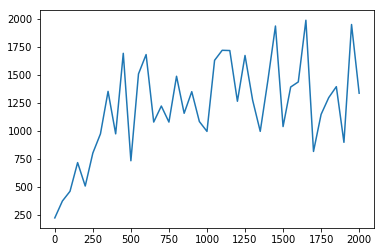

In [22]:
time,rw = zip(*sorted(list(rewards.items()),key=lambda p:p[0]))
plt.plot(time,list(map(np.mean,rw)))
    

In [25]:
import os
tmp = GAME_NAME.split('/')[1]
os.mkdir(tmp)
with open('{}/{}'.format(tmp, tmp), 'w') as outp:
    for idx in range(len(time)):
        print(time[idx], rw[idx], file=outp)

In [26]:
action_layer.epsilon.set_value(0.001)
rw = pool.evaluate(n_games=100,save_path="./records",record_video=True)
print("mean session score=%f"%np.mean(rw))

[2017-06-27 01:16:30,780] Making new env: ppaquette/DoomCorridor-v0
[2017-06-27 01:16:30,785] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-06-27 01:16:31,028] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.41.18145.video000000.mp4


Episode finished after 34 timesteps with reward=2278.692657470703


[2017-06-27 01:16:32,230] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.41.18145.video000001.mp4


Episode finished after 33 timesteps with reward=2279.1280517578125
Episode finished after 36 timesteps with reward=2283.1307525634766
Episode finished after 33 timesteps with reward=2280.5428924560547
Episode finished after 32 timesteps with reward=878.9631500244141
Episode finished after 36 timesteps with reward=2279.8557739257812
Episode finished after 30 timesteps with reward=800.676513671875


[2017-06-27 01:16:36,035] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.41.18145.video000008.mp4


Episode finished after 33 timesteps with reward=2281.4136962890625
Episode finished after 31 timesteps with reward=799.3393402099609
Episode finished after 36 timesteps with reward=2278.3609161376953
Episode finished after 33 timesteps with reward=2281.4291381835938
Episode finished after 35 timesteps with reward=2277.819305419922
Episode finished after 34 timesteps with reward=2278.4578247070312
Episode finished after 34 timesteps with reward=892.0908050537109
Episode finished after 31 timesteps with reward=1009.7021179199219
Episode finished after 32 timesteps with reward=1026.642562866211
Episode finished after 34 timesteps with reward=2276.1107330322266
Episode finished after 34 timesteps with reward=2281.4493865966797
Episode finished after 35 timesteps with reward=2278.0687713623047
Episode finished after 32 timesteps with reward=1086.9984130859375
Episode finished after 33 timesteps with reward=2276.643768310547
Episode finished after 33 timesteps with reward=2281.4036865234375


[2017-06-27 01:16:45,116] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.41.18145.video000027.mp4


Episode finished after 34 timesteps with reward=2281.0116577148438
Episode finished after 54 timesteps with reward=1071.0080871582031
Episode finished after 33 timesteps with reward=2276.4221954345703
Episode finished after 35 timesteps with reward=2277.761260986328
Episode finished after 33 timesteps with reward=2285.120803833008
Episode finished after 33 timesteps with reward=2278.1656799316406
Episode finished after 35 timesteps with reward=2284.166976928711
Episode finished after 34 timesteps with reward=2276.8358306884766
Episode finished after 38 timesteps with reward=2278.7713928222656
Episode finished after 34 timesteps with reward=2282.883743286133
Episode finished after 34 timesteps with reward=2281.2247924804688
Episode finished after 34 timesteps with reward=2287.1004028320312
Episode finished after 35 timesteps with reward=2278.4327850341797
Episode finished after 31 timesteps with reward=1076.3035430908203
Episode finished after 34 timesteps with reward=1092.6141967773438

[2017-06-27 01:17:03,128] Starting new video recorder writing to /home/ubuntu/records/openaigym.video.41.18145.video000064.mp4


Episode finished after 33 timesteps with reward=2278.4346618652344
Episode finished after 33 timesteps with reward=2280.1056213378906
Episode finished after 34 timesteps with reward=2276.0962524414062
Episode finished after 33 timesteps with reward=2276.66650390625
Episode finished after 32 timesteps with reward=1129.6983642578125
Episode finished after 33 timesteps with reward=2281.829086303711
Episode finished after 34 timesteps with reward=1162.5662994384766
Episode finished after 34 timesteps with reward=2282.6495666503906
Episode finished after 32 timesteps with reward=2283.862594604492
Episode finished after 35 timesteps with reward=2276.7298736572266
Episode finished after 40 timesteps with reward=1043.595443725586
Episode finished after 34 timesteps with reward=2282.38671875
Episode finished after 36 timesteps with reward=2277.5995025634766
Episode finished after 35 timesteps with reward=2282.7584686279297
Episode finished after 35 timesteps with reward=2277.683364868164
Episod

[2017-06-27 01:17:20,152] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Episode finished after 35 timesteps with reward=2278.9090270996094
mean session score=1985.088367


In [27]:
from agentnet.utils.persistence import save,load
#save for display
save(action_layer,"{}/{}.pcl".format(tmp, tmp))

In [28]:
save(qvalues_layer,"dist_weights/{}.pcl".format(tmp))

## Get serious

* Switch to DoomDefendCenter, DoomHealthGathering, DoomDeathmatch or similar
* Deploy a better RL algorithm
* Deploy a better network. Doom will likely need some recurrent nets